## Laborator 4 Versiune Imbunatatita

## Obiective

* familiaziraze cu tensorflow slim.
* modificarea unei retele neurale in slim
* vizualizare date input
* vizualizare activari
* tf.metrics


## Pasul 0. Upload dependinte Python#

* cifar10.py
* download.py
* dataset.py
* cache.py


In [389]:

from google.colab import files
# uploaded = files.upload()
print("OK")

OK


In [390]:
# verificam ca totul este ok
!ls .

cache.py    ckpts  datalab     download.py
cifar10.py  data   dataset.py  __pycache__


## Pasul 1. Incarcarea dataset-ului

In [0]:
import cifar10


In [392]:
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


In [393]:
!ls data/CIFAR-10

cifar-10-batches-py  cifar-10-python.tar.gz


## Pasul 2. Inspecatarea dataset-ului. Histograma + Imagini sample

In [394]:
class_names = cifar10.load_class_names()
class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [395]:
images_train, cls_train, labels_train = cifar10.load_training_data()
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


In [396]:
import numpy as np

print(images_train.shape)
print(images_test.shape)

# one hot encodings
print(labels_train.shape)
print(labels_test.shape)

# class labels
print(cls_train.shape)
print(cls_test.shape)


print("Train count {}".format(images_train.shape[0]))
print("Test count {}".format(images_test.shape[0]))

cls_ids = np.unique(cls_train)
print("Class labels {}.".format(cls_ids))

n_classes = len(cls_ids)
print("Num classes {}".format(n_classes))





(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 10)
(10000, 10)
(50000,)
(10000,)
Train count 50000
Test count 10000
Class labels [0 1 2 3 4 5 6 7 8 9].
Num classes 10


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

In [0]:
# check data statistics

def get_stats(labels):
    stats = np.zeros(n_classes)
    for e in labels:
        stats[e] += 1
    return stats
  
# bar_width = 0.
def plot_stats(stats, title):
    plt.figure()
    x = range(n_classes)
    plt.title(title)
    plt.bar(x, stats)

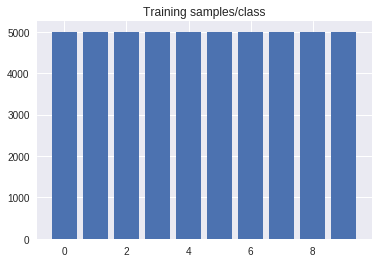

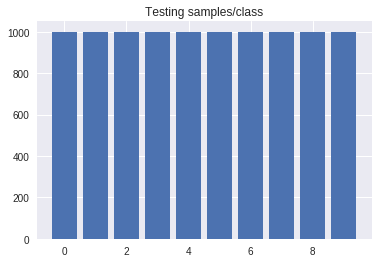

In [399]:
y_train = cls_train
y_test = cls_test

X_train = images_train
X_test = images_test

train_stats = get_stats(y_train)
test_stats = get_stats(y_test)

plt.figure()
plot_stats(train_stats, "Training samples/class")
plot_stats(test_stats, "Testing samples/class")

In [0]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

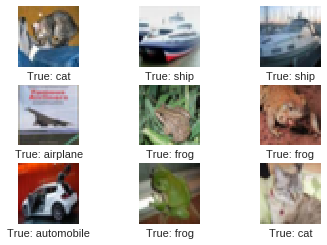

In [401]:
# Get the first images from the test-set.
images = images_test[0:9]

# Get the true classes for those images.
cls_true = cls_test[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=False)

### Vizualizati dataset-ul cu sample-uri din fiecare clasa.

In [402]:
num_samples = 10

image_shape = images_train.shape[1:]

img_height, img_width = image_shape[0], image_shape[1]

print("hxw {}x{}".format(img_height, img_width))

def draw_samples(X, y, y_target, num_cl, colormap = None):
    c_ids = np.where(y == y_target)
    selected_idx = random.sample(c_ids[0].tolist(), num_samples)
    for i, idx in enumerate(selected_idx):
        plt.subplot(num_cl, num_samples, (num_samples * y_target) + i + 1)
        plt.axis('off')
        plt.imshow(X[idx], colormap)

hxw 32x32


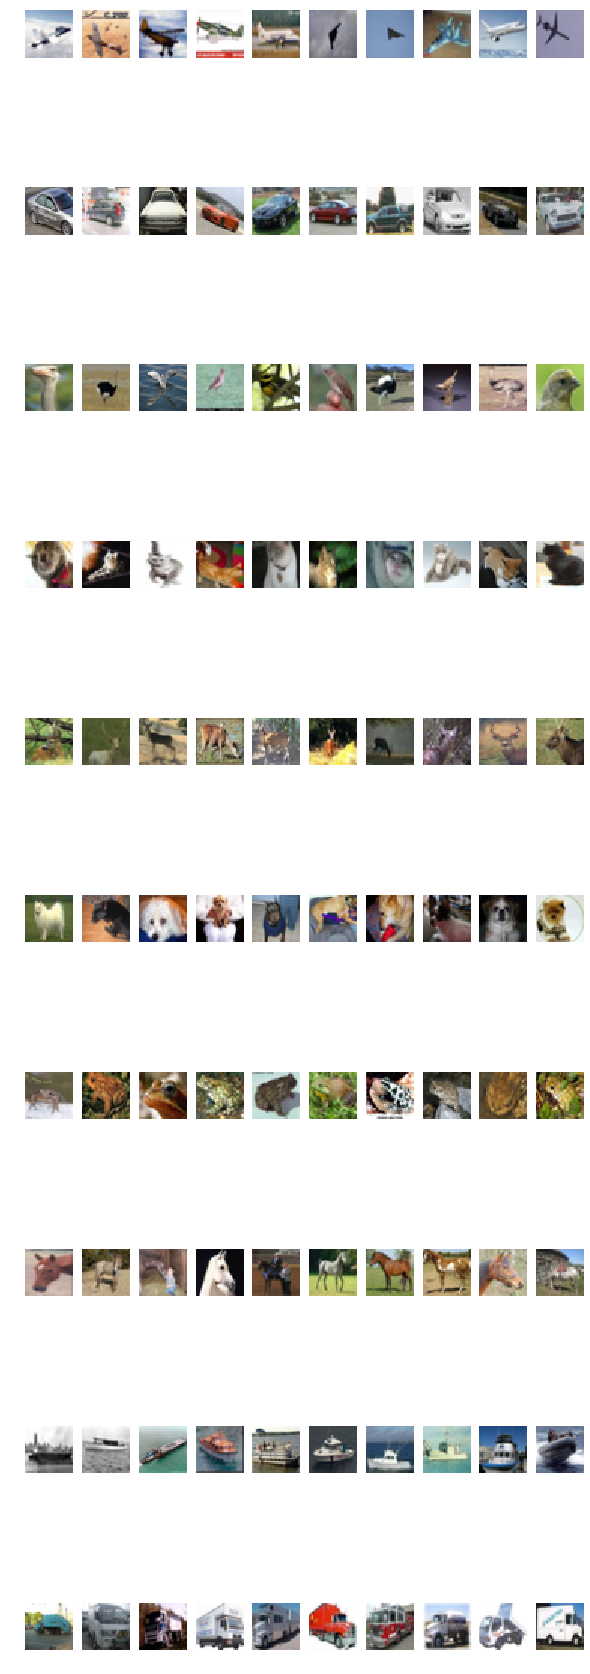

In [403]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# index = random.randint(0, len(X_train))
# image = X_train[index].squeeze()



plt.figure(figsize=(num_samples, img_width))
for c in range(n_classes):
    draw_samples(X_train, y_train, c, n_classes)
# 
# plt.imshow(image)
# plt.axis('off')
# print(y_train[index])

## Pasul 3. Definirea modelului in TensorFlow

### *Nota* Vom folosi tensoflow slim pentru a ne face viata mai usoara.

In [0]:
import tensorflow as tf

slim = tf.contrib.slim
trunc_normal = lambda stddev: tf.truncated_normal_initializer(stddev=stddev)


## Definirea unui argument scope. 

Un argument scope furnizeaza parametri default pentru operatiile din slim.
Pentru a consulta parametri default, ne putem uita direct in codul sursa:

https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/layers/python/layers/layers.py#L917

In [0]:
def cifarnet_arg_scope(weight_decay=0.004, is_training=True):
  """Defines the default cifarnet argument scope.

  Args:
    weight_decay: The weight decay to use for regularizing the model.

  Returns:
    An `arg_scope` to use for the cifarnet model.
  """
  with slim.arg_scope(
      [slim.conv2d],
      weights_initializer=tf.truncated_normal_initializer(stddev=5e-2),
      activation_fn=tf.nn.relu):
    with slim.arg_scope(
        [slim.fully_connected],
        biases_initializer=tf.constant_initializer(0.1),
        weights_initializer=trunc_normal(0.04),
        weights_regularizer=slim.l2_regularizer(weight_decay),
        normalizer_fn=None,
        activation_fn=tf.nn.relu) as sc:
      return sc


## Task 1. Adaugati normalizare pentru conv2d folosind batchn norm si argument scope.
Hints: 
* cautati argumentul care controleaza normalizarea in definitiea conv2d din slim https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/layers/python/layers/layers.py#L917
* vrem sa controlam rata de invatare si pentru batchnorm.

```
batch_norm_params = {
      'is_training': is_training,
      'center': True,
      'scale': True,
      'decay': 0.997,
      'epsilon': 0.001,
  }

```

In acest snippet de cod batch norm este configurat sa:
  * scada mean-ul
  * imparta la varianta
  * train/test e configurat prin variabila
  * momentum-ul este controlat de `decay`
  * impartirea cu 0 este previnita cu `epsilon`
  

* pentru a configura argumentele default pentr o operatie direct cu un dictionar puteti folosi apel de genul:
  `arg_scope(op_list, ** params)`

```
@tf_contextlib.contextmanager
def arg_scope(list_ops_or_scope, **kwargs):
  """Stores the default arguments for the given set of list_ops.
  For usage, please see examples at top of the file.
  Args:
    list_ops_or_scope: List or tuple of operations to set argument scope for or
      a dictionary containing the current scope. When list_ops_or_scope is a
      dict, kwargs must be empty. When list_ops_or_scope is a list or tuple,
      then every op in it need to be decorated with @add_arg_scope to work.
    **kwargs: keyword=value that will define the defaults for each op in
              list_ops. All the ops need to accept the given set of arguments.
  
```

https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/framework/python/ops/arg_scope.py#L112

 

In [0]:
def cifarnet_arg_scope_bnorm(weight_decay=0.004, is_training=True):
  """Defines the batch norm cifarnet argument scope.

  Args:
    weight_decay: The weight decay to use for regularizing the model.

  Returns:
       An `arg_scope` to use for the cifarnet model.
  """
  
  batch_norm_params = {
      'is_training': is_training,
      'center': True,
      'scale': True,
      'decay': 0.997,
      'epsilon': 0.001,
  }
  
  with slim.arg_scope(
      [slim.conv2d],
      weights_initializer=tf.truncated_normal_initializer(stddev=5e-2),
      activation_fn=tf.nn.relu6,
      normalizer_fn=slim.batch_norm):
    with slim.arg_scope([slim.batch_norm], **batch_norm_params):
      with slim.arg_scope(
          [slim.fully_connected],
          biases_initializer=tf.constant_initializer(0.1),
          weights_initializer=trunc_normal(0.04),
          weights_regularizer=slim.l2_regularizer(weight_decay),

          activation_fn=tf.nn.relu) as sc:
         
          return sc


## CifarNet

In [0]:
trunc_normal = lambda stddev: tf.truncated_normal_initializer(stddev=stddev)

def cifarnet_bn(images, num_classes=10, is_training=False,
             dropout_keep_prob=0.75,
             prediction_fn=slim.softmax,
             scope='CifarNet'):
 
  end_points = {}

  with tf.variable_scope(scope, 'CifarNet', [images]):
    net = slim.conv2d(images, 32, [5, 5], scope='conv1')
    end_points['conv1'] = net
    
    net = slim.conv2d(net, 32, [5, 5], scope='conv2')
    end_points['conv2'] = net
    net = slim.max_pool2d(net, [2, 2], 2, scope='pool2')
    end_points['pool2'] = net
    
    net = slim.conv2d(net, 64, [3, 3], scope='conv3')
    end_points['conv3'] = net
    net = slim.max_pool2d(net, [2, 2], 2, scope='pool3')
    end_points['pool3'] = net
    
    net = slim.conv2d(net, 128, [3, 3], scope='conv4')
    end_points['conv4'] = net
    net = slim.max_pool2d(net, [2, 2], 2, scope='pool4')
    end_points['pool4'] = net
    
    net = slim.conv2d(net, 128, [1, 1], scope='conv5')
    end_points['conv5'] = net
    
    net = slim.flatten(net)
    end_points['Flatten'] = net
    net = slim.fully_connected(net, 384, scope='fc3')
    end_points['fc3'] = net
    net = slim.dropout(net, dropout_keep_prob, is_training=is_training,
                       scope='dropout3')
    net = slim.fully_connected(net, 192, scope='fc4')
    end_points['fc4'] = net
    if not num_classes:
      return net, end_points
    logits = slim.fully_connected(net, num_classes,
                                  biases_initializer=tf.zeros_initializer(),
                                  weights_initializer=trunc_normal(1/192.0),
                                  weights_regularizer=None,
                                  activation_fn=None,
                                  scope='logits')

    end_points['Logits'] = logits
    end_points['Predictions'] = prediction_fn(logits, scope='Predictions')

  return logits, end_points

In [0]:
# parametri de training si input
batch_size = 64
height = 32
width = 32
channels = 3
num_classes = 10
initial_learning_rate = 0.05

### Adaugarea conexiunilor de intrare. tf.placeholders

In [0]:
def add_placeholders():

    def _process_image(image):
      # Because these operations are not commutative, consider randomizing
      # randomize the order their operation.

      augment_level = random.randint(0,2)

      if augment_level > 0:
          r = random.randint(0,1)
          if r == 1:
            image = tf.image.random_brightness(image, max_delta=30)
            image = tf.image.random_contrast(image, lower=0.75, upper=1.25)
          else:
            image = tf.image.random_contrast(image, lower=0.75, upper=1.25)
            image = tf.image.random_brightness(image, max_delta=30)
      if augment_level > 1:
          r = random.randint(0,1)
          if r == 1:
            image = tf.image.random_saturation(image, lower=0.5, upper=1.6)
            image = tf.image.random_hue(image, max_delta=0.15)
          else:
            image = tf.image.random_hue(image, max_delta=0.15)
            image = tf.image.random_saturation(image, lower=0.5, upper=1.6)

      image = tf.image.random_flip_left_right(image)

      image = tf.minimum(image, 255.0)
      image = tf.maximum(image, 0)
      return image

    # image batch input
    image_input = tf.placeholder(
        tf.float32, [None, height, width, 3],
        name='image_input'
    )

    label_input = tf.placeholder(
        tf.int64, [None],
        name='label_input'
    )

    is_training = tf.placeholder(tf.bool, name='is_training')

    learning_rate = tf.placeholder(tf.float32, shape=[])

    normalised_image_input = tf.scalar_mul((1.0 / 255), image_input)
    processed_image_input = tf.map_fn(lambda img: tf.cond(is_training, lambda: _process_image(img), lambda: img)
                                      , normalised_image_input)
    
    scaled_image_input = tf.multiply(tf.subtract(processed_image_input, 0.5), 2.0)
    
    return scaled_image_input, label_input, is_training, learning_rate


### Nota
Pentru augmentare adaugati o operatie tensorflow in input:

```

if is_training:
    scaled_input_tensor = tf.scalar_mul((1.0 / 255), _process_image(1, image_input))
else:
    scaled_input_tensor = tf.scalar_mul((1.0 / 255), self.image_input)

scaled_input_tensor = tf.subtract(scaled_input_tensor, 0.5)
self.scaled_input_tensor = tf.multiply(scaled_input_tensor, 2.0)

```

Mai sus se opereaza folosind `_process_image` augmenatere de brgithnes si saturation.
Inainte, input-ul este normalizat.

Normalizarea se efectueaza atat la training cat si la testing.
Augmentarea se efectueaza doar la testing si are rol in generelizare.

Puteti folosi si horizontal flipping `tf.image.random_flip_left_right`

https://www.tensorflow.org/api_docs/python/tf/image/random_flip_left_right


In [422]:
images_train.shape

(50000, 32, 32, 3)

In [423]:
labels_train.shape

(50000, 10)

In [424]:
np.unique(cls_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

### Functie helper pentru a incarca un minibatch random la training

In [0]:
def random_batch(img, labels):
    # Number of images in the training-set.
    num_images = len(img)
    #     print(num_images)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = img[idx, :, :, :]
    y_batch = labels[idx]

    return x_batch, y_batch

In [426]:
x, y = random_batch(X_train, y_train)

y.shape

(64,)

### Functie helper pentru obtinirea unui batch la test. Nu facem shuffle la test

In [427]:
def get_batch(imgs, labels, step):
  offset = (step * batch_size) % (labels.shape[0] - batch_size)
#   print(offset)
  batch_imgs = imgs[offset:(offset + batch_size), :, :, :]
  batch_labels = labels[offset:(offset + batch_size)]
  
  return batch_imgs, batch_labels
  
batch_imgs, batch_labels = get_batch(images_test, cls_test, 2)
  
print(batch_imgs.shape)
print(batch_labels.shape)
  

(64, 32, 32, 3)
(64,)


### Functie pentru evaluare acuratete

In [0]:
#evaluate model



def evaluate():
  total_examples = cls_test.shape[0]  
  iters = int(total_examples/batch_size)
#   print("Total examples {}".format(total_examples))
#   print("Total iters {}".format(iters))
  
  
  acc = []
  losses = []
    
  for i in range(iters):
    
    x, y = get_batch(images_test, cls_test, i)

    feed_dict = {

        image_input: x,
        label_input: y,
        is_training: False

    }

    testAcc, testLoss = sess.run([accuracy, loss], feed_dict=feed_dict)
    acc.append(testAcc)
    losses.append(testLoss)
    #if i % 100 == 0:
    #  print("Test " + str(i) + ": accuracy:" + str(testAcc) + " loss: " + str(testLoss))
    
      
#   print(acc)
  meanAcc = np.mean(np.asarray(acc))
  meanLoss = np.mean(np.asarray(losses))
  
#   print("Test Accuracy {:.2f} %".format(meanAcc * 100))
  
  return meanAcc, meanLoss
  
  
#evaluate()               


In [0]:
trainingAccuracyList = []
trainingLossList = []
testAccuracyList = []
testLossList = []
learningRateList = []

### Definirea pasilor de antrenare

In [430]:

num_steps = 50000
num_examples = images_train.shape[0]
iters = num_examples / batch_size
learning_rate_step = 10000
learning_rate_decay = 0.1

tf.reset_default_graph()

g = tf.Graph().as_default()
image_input, label_input, is_training, learning_rate = add_placeholders()
arg_scope = cifarnet_arg_scope_bnorm(is_training=is_training)
with slim.arg_scope(arg_scope):
  logits, end_points = cifarnet_bn(image_input, is_training=is_training)

loss = tf.reduce_mean(
  tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label_input, logits=logits))

# accuracy of the trained model, between 0 (worst) and 1 (best)
predictions = end_points['Predictions']

correct_prediction = tf.equal(tf.argmax(predictions, 1), label_input)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


init = tf.global_variables_initializer()


sess = tf.Session()
# actually initialize our variables
sess.run(init)



# Optimizer.
# optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

# for batch norm training. Note: we should use slim.train_op

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
  # Ensures that we execute the update_ops before performing the train_step
  optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)
  
  
  
running_lr = initial_learning_rate

print("Starting optimization")
print("Initial LR {}. LR stepdown itnerval {}. LR deacy factor {}".format(running_lr, learning_rate_step, learning_rate_decay))

for i in range(num_steps):
  x, y = random_batch(X_train, y_train)

  feed_dict = {

      image_input: x,
      label_input: y,
      is_training: True,
      learning_rate : running_lr

  }

  if i % 200 == 0:
      _, trainAcc, trainLoss = sess.run([optimizer, accuracy, loss], feed_dict=feed_dict)
      
      testAcc, testLoss = evaluate()
      
      print("Train " + str(i) + ": accuracy:" + str(trainAcc) + " loss: " + str(trainLoss))
      print("Test " + str(i) + ": accuracy:" + str(testAcc) + " loss: " + str(testLoss))
      
      trainingAccuracyList.append(trainAcc)
      trainingLossList.append(trainLoss)
      testAccuracyList.append(testAcc)
      testLossList.append(testLoss)
      learningRateList.append(running_lr)
     
  else:
      sess.run([optimizer], feed_dict=feed_dict)
  
  
  if  i > 0 and i % learning_rate_step == 0:
      print("Learning reate step down. Old {}. New {}".format(running_lr, running_lr * learning_rate_decay))
      running_lr = running_lr * learning_rate_decay
      
          
    




      

Starting optimization
Initial LR 0.05. LR stepdown itnerval 10000. LR deacy factor 0.1
Train 0: accuracy:0.09375 loss: 2.3062348
Test 0: accuracy:0.099859774 loss: 2.3026955
Train 200: accuracy:0.328125 loss: 1.6791675
Test 200: accuracy:0.114983976 loss: 2.4740071
Train 400: accuracy:0.5625 loss: 1.2451429
Test 400: accuracy:0.17758414 loss: 2.3716583
Train 600: accuracy:0.453125 loss: 1.2742608
Test 600: accuracy:0.21714744 loss: 2.201869
Train 800: accuracy:0.515625 loss: 1.175237
Test 800: accuracy:0.37429887 loss: 1.7394992
Train 1000: accuracy:0.65625 loss: 1.1199999
Test 1000: accuracy:0.5665064 loss: 1.1957284
Train 1200: accuracy:0.6875 loss: 0.9366234
Test 1200: accuracy:0.5588942 loss: 1.240844
Train 1400: accuracy:0.59375 loss: 1.0285522
Test 1400: accuracy:0.5095152 loss: 1.4377401
Train 1600: accuracy:0.703125 loss: 0.8240106
Test 1600: accuracy:0.48627806 loss: 1.4965351
Train 1800: accuracy:0.703125 loss: 0.7086488
Test 1800: accuracy:0.66997194 loss: 0.933131
Train 200

Train 9000: accuracy:0.9375 loss: 0.21697965
Test 9000: accuracy:0.7478966 loss: 0.87022597
Train 9200: accuracy:0.953125 loss: 0.108479135
Test 9200: accuracy:0.7313702 loss: 1.0022068
Train 9400: accuracy:0.953125 loss: 0.27703032
Test 9400: accuracy:0.75821316 loss: 0.8545678
Train 9600: accuracy:0.953125 loss: 0.14517745
Test 9600: accuracy:0.7668269 loss: 0.8207196
Train 9800: accuracy:0.9375 loss: 0.15268555
Test 9800: accuracy:0.75590944 loss: 0.84708834
Train 10000: accuracy:0.9375 loss: 0.15302731
Test 10000: accuracy:0.7459936 loss: 0.962339
Learning reate step down. Old 0.05. New 0.005000000000000001
Train 10200: accuracy:0.953125 loss: 0.14142406
Test 10200: accuracy:0.7895633 loss: 0.7586957
Train 10400: accuracy:0.984375 loss: 0.08215047
Test 10400: accuracy:0.79627407 loss: 0.74236935
Train 10600: accuracy:0.953125 loss: 0.1206466
Test 10600: accuracy:0.7979768 loss: 0.7344133
Train 10800: accuracy:0.953125 loss: 0.08786841
Test 10800: accuracy:0.79967946 loss: 0.7382342

Train 18000: accuracy:1.0 loss: 0.030107241
Test 18000: accuracy:0.79827726 loss: 0.85250133
Train 18200: accuracy:0.984375 loss: 0.07479573
Test 18200: accuracy:0.79877806 loss: 0.8552141
Train 18400: accuracy:0.984375 loss: 0.08883018
Test 18400: accuracy:0.7985777 loss: 0.858449
Train 18600: accuracy:0.953125 loss: 0.1218126
Test 18600: accuracy:0.7990785 loss: 0.8632501
Train 18800: accuracy:0.984375 loss: 0.03259749
Test 18800: accuracy:0.79827726 loss: 0.8732764
Train 19000: accuracy:1.0 loss: 0.019339379
Test 19000: accuracy:0.79877806 loss: 0.86469805
Train 19200: accuracy:0.984375 loss: 0.03684181
Test 19200: accuracy:0.8006811 loss: 0.86736804
Train 19400: accuracy:0.984375 loss: 0.032069333
Test 19400: accuracy:0.7995793 loss: 0.87083787
Train 19600: accuracy:1.0 loss: 0.014735904
Test 19600: accuracy:0.7990785 loss: 0.8764809
Train 19800: accuracy:0.984375 loss: 0.032805044
Test 19800: accuracy:0.79867786 loss: 0.8736903
Train 20000: accuracy:0.953125 loss: 0.10585308
Test 

KeyboardInterrupt: ignored

### Plotting

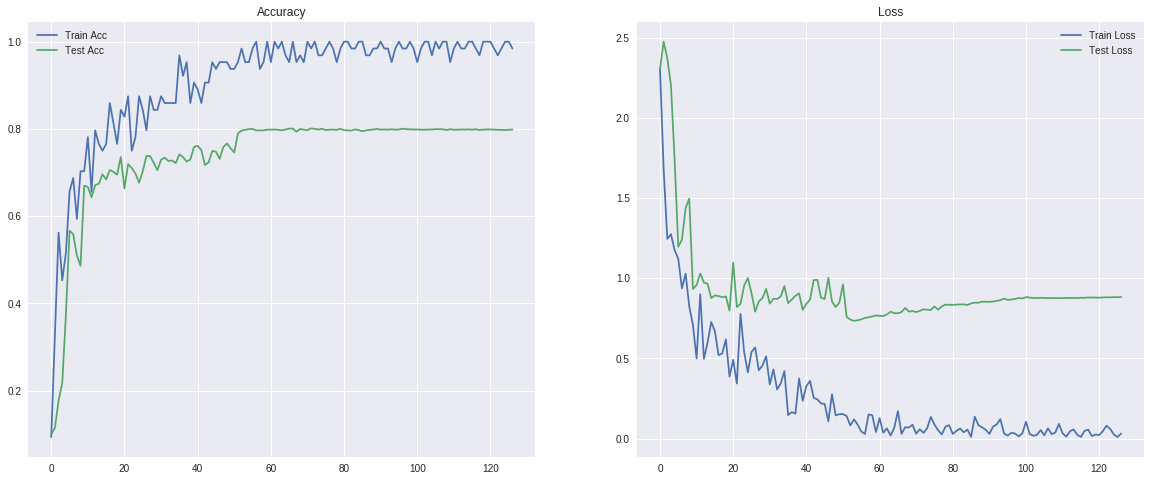

In [431]:
plt.figure(figsize=(20,8))

# Plot Accuracy
plt.subplot(1,2,1);
plt.plot(trainingAccuracyList, label="Train Acc");
plt.plot(testAccuracyList, label="Test Acc");
plt.title("Accuracy");
plt.legend();

# Plot Loss
plt.subplot(1,2,2);
plt.plot(trainingLossList, label="Train Loss");
plt.plot(testLossList, label="Test Loss");
plt.title("Loss");
plt.legend();

In [446]:
import heapq

def ex3():
  
  choices = np.random.choice(len(labels_test), 5, replace=False)
  
  for i in range(5):
    x = [images_test[choices[i]]]
    y = labels_test[choices[i]]
    print(y)

    feed_dict = {
          image_input: x,
          label_input: y,
          is_training: False
      }

    probs = sess.run([end_points['Predictions']], feed_dict=feed_dict)

    print(heapq.nlargest(3, probs[0][0]))
  

ex3()

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0.9978927, 0.0019768006, 0.00012218648]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0.9994481, 0.0004033976, 0.00014684814]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0.9991529, 0.00084145245, 5.5088935e-06]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0.92882997, 0.07109111, 6.981244e-05]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0.9645292, 0.035470307, 3.1457552e-07]


## Evaluate final model

In [447]:

  
acc, test_loss = evaluate()

print("Test accuracy:" + str(acc) + " loss: " + str(test_loss))
                   

Test accuracy:0.7988782 loss: 0.88141316


### Nota

* Fara batch norm: accuracy 73 %
* Cu batch norm: accuracy ~ 78 %

## Save a model checkpoint. Restoring a model checkpoint

In [448]:
# Save / restore model

#!mkdir ckpts

vars_to_save = tf.global_variables()
saver = tf.train.Saver(var_list=vars_to_save)


model_name ='./ckpts/cifarnet-batchnorm.ckpt'
saver.save(sess, model_name, global_step=num_steps)
print(vars_to_save)

[<tf.Variable 'CifarNet/conv1/weights:0' shape=(5, 5, 3, 32) dtype=float32_ref>, <tf.Variable 'CifarNet/conv1/BatchNorm/gamma:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'CifarNet/conv1/BatchNorm/beta:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'CifarNet/conv1/BatchNorm/moving_mean:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'CifarNet/conv1/BatchNorm/moving_variance:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'CifarNet/conv2/weights:0' shape=(5, 5, 32, 32) dtype=float32_ref>, <tf.Variable 'CifarNet/conv2/BatchNorm/gamma:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'CifarNet/conv2/BatchNorm/beta:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'CifarNet/conv2/BatchNorm/moving_mean:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'CifarNet/conv2/BatchNorm/moving_variance:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'CifarNet/conv3/weights:0' shape=(3, 3, 32, 64) dtype=float32_ref>, <tf.Variable 'CifarNet/conv3/BatchNorm/gamma:0' shape=(64,) dtype=float32_ref>, <tf.Var

## Exmplu calcul acuratete folosint tf.metrics

`tf.metrics.accuracy` 

```
labels = ...
predictions = ...
accuracy, update_op_acc = tf.metrics.accuracy(
    labels, predictions)
error, update_op_error = tf.metrics.mean_absolute_error(
    labels, predictions)

sess.run(tf.local_variables_initializer())
for batch in range(num_batches):
  sess.run([update_op_acc, update_op_error])

accuracy, mean_absolute_error = sess.run([accuracy, mean_absolute_error])

```

https://www.tensorflow.org/api_docs/python/tf/metrics


## Testing model restore works

In [449]:
# test restore works
evaluate()
sess.run(init)
evaluate()
vars_to_restore = tf.global_variables()
saver = tf.train.Saver(var_list=vars_to_restore)
model_to_restore = "{}-{}".format(model_name, num_steps)
saver.restore(sess, model_to_restore)
evaluate()

INFO:tensorflow:Restoring parameters from ./ckpts/cifarnet-batchnorm.ckpt-50000


(0.7988782, 0.88141316)

In [0]:
#!ls ./ckpts

### One hot encoding

In [451]:
x, y = get_batch(images_test, cls_test, i)

y = y[:4]
print(y)
print(num_classes)

res = tf.one_hot(indices=y, depth=num_classes)
print(sess.run(res))

[2 6 7 6]
10
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


### Masurarea performantelor retelei folosind tf.metrics

In [452]:
# Remember

# predictions = end_points['Predictions']
# correct_prediction = tf.equal(tf.argmax(predictions, 1), label_input)
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# adaugam on nod pentru one hot

labels = tf.one_hot(indices=label_input, depth=num_classes)
# accuracy_streamed, update_op_acc = tf.contrib.metrics.streaming_accuracy(label_input, tf.argmax(predictions, 1))

accuracy_streamed, update_op_acc = tf.metrics.accuracy(label_input, tf.argmax(predictions, 1))

# init = tf.global_variables_initializer()
sess.run(tf.local_variables_initializer())
  

vars_to_restore = tf.global_variables()
saver = tf.train.Saver(var_list=vars_to_restore)
saver.restore(sess, model_to_restore)

evaluate()


INFO:tensorflow:Restoring parameters from ./ckpts/cifarnet-batchnorm.ckpt-50000


(0.7988782, 0.88141316)

In [453]:



def evaluate_streaming():
  total_examples = cls_test.shape[0]
  num_batches = int(total_examples / batch_size)
  print("Total examples {}".format(total_examples))
  print("Total iters {}".format(num_batches))
  
  for i in range(num_batches):
    
    x, y = get_batch(images_test, cls_test, i)

    feed_dict = {

        image_input: x,
        label_input: y,
        is_training: False

    }

    #testAcc, testLoss = sess.run([accuracy, loss], feed_dict=feed_dict)
    
    if i % 10 == 0:
      _, test_acc = sess.run([update_op_acc, accuracy_streamed],  feed_dict=feed_dict)
      print("Test " + str(i) + ": accuracy:" + str(test_acc))
    
    else:
      sess.run([update_op_acc], feed_dict=feed_dict)
    
      
  test_acc = sess.run(accuracy_streamed)
  print("Mean Accuracy  {:.2f} %".format(test_acc * 100))
  
  
evaluate_streaming()

Total examples 10000
Total iters 156
Test 0: accuracy:0.0
Test 10: accuracy:0.8359375
Test 20: accuracy:0.82109374
Test 30: accuracy:0.8197917
Test 40: accuracy:0.8070313
Test 50: accuracy:0.8059375
Test 60: accuracy:0.8002604
Test 70: accuracy:0.80513394
Test 80: accuracy:0.8029297
Test 90: accuracy:0.8046875
Test 100: accuracy:0.8020313
Test 110: accuracy:0.79971594
Test 120: accuracy:0.7997396
Test 130: accuracy:0.7980769
Test 140: accuracy:0.7969866
Test 150: accuracy:0.79854167
Mean Accuracy  79.89 %


In [454]:
def evaluate_class(cls_no):
  
  total_examples = cls_test.shape[0]  
  iters = int(total_examples/batch_size)
#   print("Total examples {}".format(total_examples))
#   print("Total iters {}".format(iters))
  
  acc = []
  losses = []
  
  curr_indx = [i for i, el in enumerate(cls_test) if el == cls_no]
  curr_images_test = images_test[curr_indx]
  curr_cls_test = cls_test[curr_indx]
  
  for i in range(iters):
    
    x, y = get_batch(curr_images_test, curr_cls_test, i)

    feed_dict = {

        image_input: x,
        label_input: y,
        is_training: False

    }

    #testAcc, testLoss = sess.run([accuracy, loss], feed_dict=feed_dict)
    
    if i % 10 == 0:
      _, test_acc = sess.run([update_op_acc, accuracy_streamed],  feed_dict=feed_dict)
      print("Test " + str(i) + ": accuracy:" + str(test_acc))
    
    else:
      sess.run([update_op_acc], feed_dict=feed_dict)
    
      
  test_acc = sess.run(accuracy_streamed)
  print("Mean Accuracy  {:.2f} %".format(test_acc * 100))
  
  

evaluate_class(4)

Test 0: accuracy:0.7988782
Test 10: accuracy:0.79743975
Test 20: accuracy:0.79545456
Test 30: accuracy:0.79334676
Test 40: accuracy:0.79209185
Test 50: accuracy:0.7907312
Test 60: accuracy:0.78913486
Test 70: accuracy:0.78802544
Test 80: accuracy:0.7873411
Test 90: accuracy:0.78607726
Test 100: accuracy:0.7850952
Test 110: accuracy:0.7848332
Test 120: accuracy:0.7836277
Test 130: accuracy:0.7823427
Test 140: accuracy:0.78241134
Test 150: accuracy:0.78145427
Mean Accuracy  78.12 %


## Task (pentru acasa). Masurati acuratetea modelului pe clasa

## Variabile locale vs Variabile globale

In [455]:
tf.local_variables()

[<tf.Variable 'accuracy/total:0' shape=() dtype=float32_ref>,
 <tf.Variable 'accuracy/count:0' shape=() dtype=float32_ref>]

In [456]:
tf.global_variables()

[<tf.Variable 'CifarNet/conv1/weights:0' shape=(5, 5, 3, 32) dtype=float32_ref>,
 <tf.Variable 'CifarNet/conv1/BatchNorm/gamma:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'CifarNet/conv1/BatchNorm/beta:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'CifarNet/conv1/BatchNorm/moving_mean:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'CifarNet/conv1/BatchNorm/moving_variance:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'CifarNet/conv2/weights:0' shape=(5, 5, 32, 32) dtype=float32_ref>,
 <tf.Variable 'CifarNet/conv2/BatchNorm/gamma:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'CifarNet/conv2/BatchNorm/beta:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'CifarNet/conv2/BatchNorm/moving_mean:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'CifarNet/conv2/BatchNorm/moving_variance:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'CifarNet/conv3/weights:0' shape=(3, 3, 32, 64) dtype=float32_ref>,
 <tf.Variable 'CifarNet/conv3/BatchNorm/gamma:0' shape=(64,) dtype=float32_re

In [457]:
!ls ckpts

checkpoint
cifarnet-baseline.ckpt-50000.data-00000-of-00001
cifarnet-baseline.ckpt-50000.index
cifarnet-baseline.ckpt-50000.meta
cifarnet-batchnorm.ckpt-50000.data-00000-of-00001
cifarnet-batchnorm.ckpt-50000.index
cifarnet-batchnorm.ckpt-50000.meta


# Vizualizarea Activarilor din retea

In [458]:
# visualize endpoints
end_points


{'Flatten': <tf.Tensor 'CifarNet/Flatten/flatten/Reshape:0' shape=(?, 2048) dtype=float32>,
 'Logits': <tf.Tensor 'CifarNet/logits/BiasAdd:0' shape=(?, 10) dtype=float32>,
 'Predictions': <tf.Tensor 'CifarNet/Predictions/Reshape_1:0' shape=(?, 10) dtype=float32>,
 'conv1': <tf.Tensor 'CifarNet/conv1/Relu6:0' shape=(?, 32, 32, 32) dtype=float32>,
 'conv2': <tf.Tensor 'CifarNet/conv2/Relu6:0' shape=(?, 32, 32, 32) dtype=float32>,
 'conv3': <tf.Tensor 'CifarNet/conv3/Relu6:0' shape=(?, 16, 16, 64) dtype=float32>,
 'conv4': <tf.Tensor 'CifarNet/conv4/Relu6:0' shape=(?, 8, 8, 128) dtype=float32>,
 'conv5': <tf.Tensor 'CifarNet/conv5/Relu6:0' shape=(?, 4, 4, 128) dtype=float32>,
 'fc3': <tf.Tensor 'CifarNet/fc3/Relu:0' shape=(?, 384) dtype=float32>,
 'fc4': <tf.Tensor 'CifarNet/fc4/Relu:0' shape=(?, 192) dtype=float32>,
 'pool2': <tf.Tensor 'CifarNet/pool2/MaxPool:0' shape=(?, 16, 16, 32) dtype=float32>,
 'pool3': <tf.Tensor 'CifarNet/pool3/MaxPool:0' shape=(?, 8, 8, 64) dtype=float32>,
 'po

In [0]:
def plotActivations(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        ax = plt.gca()
        ax.grid(False)
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

In [0]:
conv1 = end_points['conv1']

x, y = random_batch(X_train, y_train)

feed_dict = {

      image_input: x,
      label_input: y,
      is_training: False

  }

conv1_fmaps = sess.run(conv1, feed_dict=feed_dict)
conv1_fmaps.shape
activ1 = conv1_fmaps[0, :, :, :]




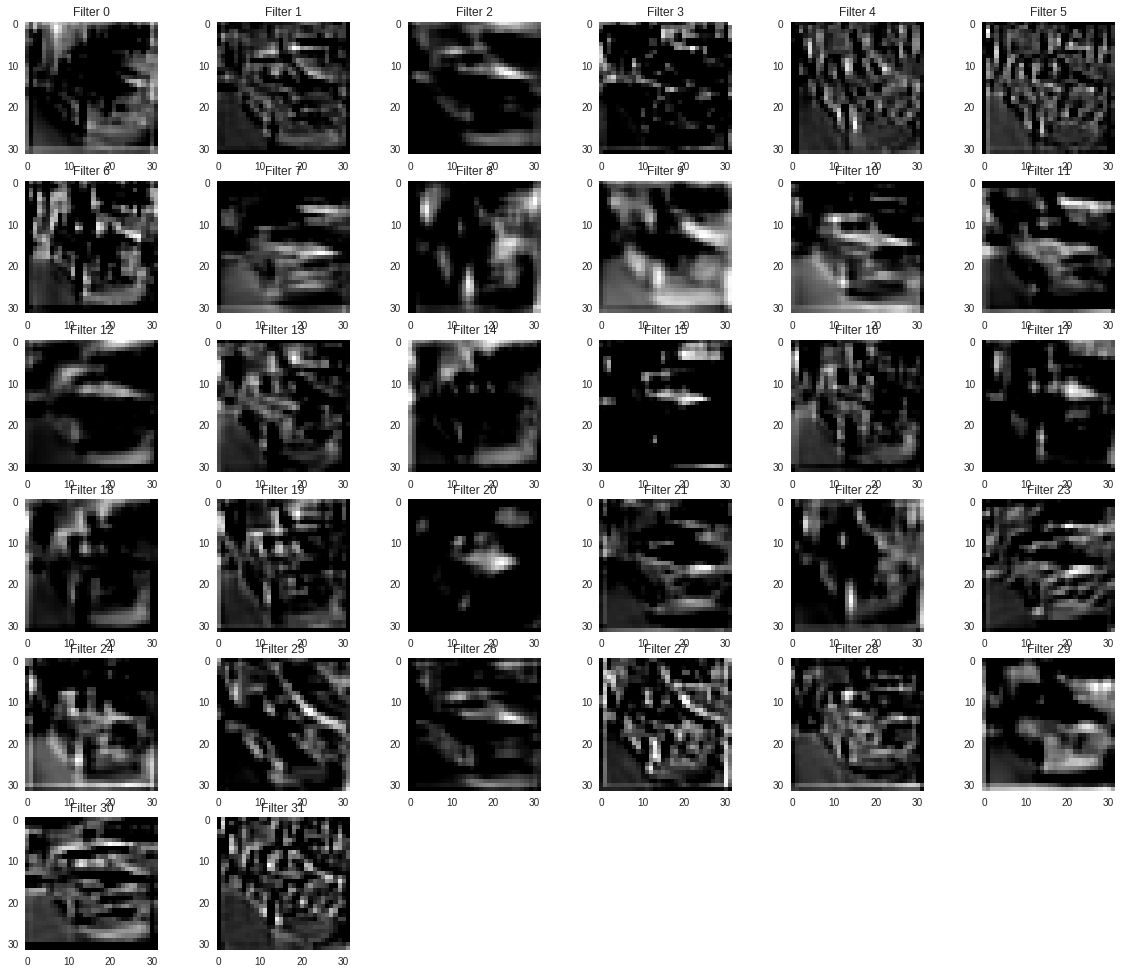

In [461]:
plotActivations(conv1_fmaps)

## Next Steps

### In clasa

1. Modificati parametri convolutiilor si dense (fully connected), * pastrand constanta arhitectura retelei* (doar din argument_scope diferit)
   Aveti in vedere:
    * Tipul de activare (relu, tanh)
    * Adaugati regularizare, normalizare batchnorm
    * optional input preprocessing
    * Adaugati batch norm si trageti concluzii

2. Observati layer-ele de MaxPooling2D. Ce fac aceste layere? Cu ce puteti inlocui layer-ul maxpool2d pastrand efectul pe dimensiuni?
  
Trageti concluzii in baza observatiilor.
Hints:
  * learning-rate-ul poate fi modificat
  * poate fi schimbat optimizatorul
  * lasati la antrenat cam 30 - 90 de epoci. Eu am antrenat 100K iteratii cu batch size 32. Pentru 50k imagini de train, inseamna 60 epoci.
  * Cu batch norm veti osberva diferenta in training.





### Acasa

** (10 p) ** 


1. Feel free sa experimentati pe CIFAR-10 cu:
  * arhitecturi imbunatatite 
  * data normalization
  * data augmentation
  * target-ul de performanta este > 78 %.
  
2. Masurarea acuratetii pe clasa.
3. Afisati top-3 probabilitati Sotfmax pentru 5 imagini impreauna cu clasa corespunzatoare. Puteti folosi matplotlib pentru a afisa probaiblitatile sub forma de barchart

Nota:

Pentru augmentare puteti folosi codul deja existent mai sus in functia ` def _process_image(augment_level, image)`. Aadaugati o operatie tensorflow in input:

```

if is_training:
    scaled_input_tensor = tf.scalar_mul((1.0 / 255), _process_image(1, image_input))
else:
    scaled_input_tensor = tf.scalar_mul((1.0 / 255), self.image_input)

scaled_input_tensor = tf.subtract(scaled_input_tensor, 0.5)
self.scaled_input_tensor = tf.multiply(scaled_input_tensor, 2.0)

```

Mai sus se opereaza folosind `_process_image` augmenatere de brightnes si saturation.
Inainte, input-ul este normalizat.


Normalizarea se efectueaza atat la training cat si la testing.
Augmentarea se efectueaza doar la testing si are rol in generelizare.

Puteti folosi si horizontal flipping `tf.image.random_flip_left_right`

https://www.tensorflow.org/api_docs/python/tf/image/random_flip_left_right




** Bonus **

### Project: Build a Traffic Sign Recognition Program ###

Dataset-ul CIFAR-10 are clasele balansate si doar 10 clase.
Dataset-ul German Traffic Signs are clasele nebalansate. Astfel va beneficia mai mult de data augmentation.

Mai multe detalii gasiti la:

https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/Traffic_Sign_Classifier.ipynb
https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project


### Pasi pentru proiect ###
1. Descracati dataset-ul
https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip
2. Clonati proiectul
git clone https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project

3. Urmariti pasii din notebook
cd CarND-Traffic-Sign-Classifier-Project
Launch the Jupyter notebook: jupyter notebook Traffic_Sign_Classifier.ipynb

4. Acuratetea target este > 93 %

Hint: Puteti incepe cu LeNet ca baseline.






